In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

PATH_N = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-dash\\data\\'
PATH_C = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Veneta\\Dados Winbooks\\Despesas e Custos\\'
PATH = 'C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Veneta\\Dados Winbooks\\Estoques\\'

# Lista dos títulos do PNLD
PNLD = ['CAROLINA - 0991L18606130IL',
        'ANGOLA JANGA - 1132L18606130IL',
        'CUMBE - 1146L18606130IL',
        'Angola Janga - 1132L - e-pub',
        'Carolina - 0991L - e-pub',
        'Cumbe - 1146L - e-pub']

# Agrupamento de Títulos
AGRP_TIT = {'9788595710207': ('9788563137203', 'Cumbe'),
            '9788595710214': ('9788563137036', 'A arte de Voar'),
            '9788595710399': ('9788563137586', 'Carolina'),
            '9786586691009': ('9788563137562', 'Matadouro de Unicornios'),}

# Le arquivo de Movimentos Access (Notas)
notas = pd.read_pickle(PATH_N + 'Notas.pkl')

# Agrupa por Mês
resumo = notas.groupby(
    [pd.Grouper(key='Emissao', freq='MS'),
        'Titulo']).aggregate({'Receita Líquida': 'sum', 'Vendas': 'sum'})
resumo.reset_index(inplace=True)

# Exclui Títulos do PNLD
resumo = resumo.loc[~resumo['Titulo'].isin(PNLD)]

# Coloca ISBN
resumo = resumo.merge(pd.read_excel(PATH_C + 'Cadastro de Produtos.xlsx',
                                    usecols='A,D', header=0, dtype=str,
                                    names=['ISBN', 'Titulo']).dropna(),
                      how='left', on='Titulo')

# Substitui títulos das segundas edições
key = resumo['ISBN'].isin(AGRP_TIT.keys())
resumo.loc[key, 'Titulo'] = resumo.loc[key,
                                       'ISBN'].map(lambda x: AGRP_TIT[x][1])
resumo.loc[key, 'ISBN'] = resumo.loc[key, 'ISBN'].map(lambda x: AGRP_TIT[x][0])
del key

# Agrega vendas dos títulos da segunda edição
resumo = resumo.groupby(['ISBN', 'Titulo',
                         pd.Grouper(key='Emissao', freq='MS')])\
            .sum().reset_index()

# Coloca coluna da data de lançamento dos títulos
lanc = resumo.loc[resumo['Vendas'] != 0, :].groupby('ISBN')['Emissao'].idxmin()
lanc = resumo.loc[lanc, ['ISBN', 'Emissao']].rename({'Emissao': 'Lancamento'},
                                                    axis=1)

resumo = resumo.loc[resumo['Vendas'] != 0].merge(lanc, how='left', on='ISBN')\
            .sort_values(['Lancamento', 'ISBN', 'Emissao'])
del lanc
            
# Coluna para separar Impresso e e-book
resumo['ebook'] = resumo['Titulo'].str.contains('e-?book|e-?pub', case=False)

# Coluna indica se é Lançamento (True) ou Catálogo (False)
resumo['Lanc/Cat'] = ((resumo['Emissao'].dt.year - resumo['Lancamento'].dt.year) * 12 + resumo['Emissao'].dt.month - resumo['Lancamento'].dt.month) < 6

In [2]:
# Resumo Mensal de Receita e Número de Exemplares (Impresso e e-book)
aux = resumo.pivot_table(values=['Receita Líquida', 'Vendas'],
                         index=[pd.Grouper(key='Emissao', freq='Y')],
                         columns=['ebook'],
                         aggfunc='sum',
                         fill_value=0)

lanc = resumo.groupby(['ebook', 'ISBN'], as_index=False)['Emissao'].min()\
        .groupby(['ebook', 'Emissao']).size().to_frame(name='Lançamentos')\
        .pivot_table(index='Emissao', columns='ebook', aggfunc='sum',
                     fill_value=0)
        
lanc = lanc.reset_index().groupby(pd.Grouper(key='Emissao', freq='YS'))\
        [[('Lançamentos', False), ('Lançamentos', True)]].sum()

## Receita Anual por Tipo de Publicação

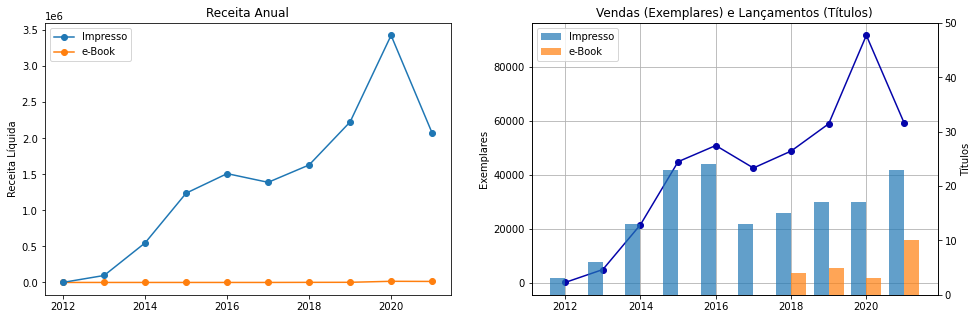

In [3]:
# Evolutivo de Vendas Anuais
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 2, 1)

x = aux.index.get_level_values(0).year
y = aux[('Receita Líquida', False)]
ax1.plot(x, y, label='Impresso', marker='o')
y = aux[('Receita Líquida', True)]
ax1.plot(x, y, label='e-Book', marker='o', zorder=0)

ax1.set_ylabel('Receita Líquida')
ax1.set_title('Receita Anual')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)

y = aux[('Vendas', False)]
ax2.plot(x, y, label='Títulos', marker='o', color='xkcd:royal blue')

width = 0.4
secax = ax2.twinx()
secax.set_ylim([0, 50])
x = lanc.index.get_level_values(0).year
y = lanc[('Lançamentos', False)]
secax.bar(x - width/2, y, width=width, label='Impresso', alpha=0.7)

y = lanc[('Lançamentos', True)]
secax.bar(x + width/2, y, width=width, label='e-Book', alpha=0.7)


ax2.set_ylabel('Exemplares')
secax.set_ylabel('Títulos')
ax2.set_title('Vendas (Exemplares) e Lançamentos (Títulos)')
secax.legend(loc='upper left')
ax2.grid()

plt.show()

## Receita Líquida e Quantidade de Títulos Lançados por Ano

In [4]:
a = aux[('Receita Líquida',)]
a.index = a.index.strftime('%Y')
a.columns = ['Impresso', 'e-Book']
a.index.name = 'Ano'
a = a.applymap(lambda x: '{:,.0f}'.format(x).replace(',', '.'))

b = lanc.reset_index().groupby(pd.Grouper(key='Emissao', freq='YS'))\
        [[('Lançamentos', False), ('Lançamentos', True)]].sum()

b.index = b.index.strftime('%Y')
b.index.name = 'Ano'
b.columns = ['Impresso', 'e-Book']
b = b.applymap(lambda x: '{:,.0f}'.format(x).replace(',', '.'))


In [5]:
display(HTML('<table style="width:80%">' +
             '<thead>' +
             '<tr><th style="text-align:left">Receita Líquida</th>' +
             '<th style="text-align:left">Qtd. Lançamentos</th></tr>' +
             '</thead>' +
             '<tbody>' +
             '<tr><td>' + a.to_html() +
             '</td><td>' + b.to_html() + '</td></tr>' +
             '</tbody>' +
             '</table>'))


## Títulos lançados em 2021

In [6]:
a = resumo.loc[(resumo['Lancamento'].dt.year == 2021) &
           (~resumo['ebook']), ['Titulo', 'Lancamento']].drop_duplicates().sort_values('Lancamento').set_index('Titulo')

a['Lancamento'] = a['Lancamento'].map(lambda x: x.strftime('%d-%b-%Y'))

a

,Lancamento
Titulo,
GUERRA DO DESERTO,01-jan-2021
DOMEX,01-fev-2021
FUN,01-mar-2021
EU FUI UM GAROTO GORILA,01-mar-2021
AS ALMAS DO POVO NEGRO,01-mar-2021
"SUZY KING, A PITONISA DA MODERNIDADE",01-mar-2021
A ABOLICAO DO TRABALHO,01-abr-2021
GROUCHO MARXISMO,01-abr-2021
O GRANDE XARAM,01-mai-2021


## Receitas de Lançamentos em 2021

In [7]:
a = resumo.loc[(resumo['Emissao'].dt.year == 2021) & resumo['Lanc/Cat']]

a = a.pivot_table(index='Titulo',
                  values='Receita Líquida',
                  columns=pd.Grouper(key='Emissao', freq='MS'),
                  aggfunc='sum',
                  fill_value=0)

a.columns = a.columns.strftime('%b-%y')

a['Total'] = a.sum(axis=1)

a.sort_values('Total', ascending=False, inplace=True)
tot_l = a.sum()
tot_l.name = 'Total'
a = a.append(tot_l)
a.applymap(lambda x: '{:,.0f}'.format(x).replace(',', '.'))


Emissao,jan-21,fev-21,mar-21,abr-21,mai-21,jun-21,jul-21,ago-21,set-21,Total
Titulo,,,,,,,,,,
PALESTINA,0,0,0,0,0,0,0,0,121.340,121.340
FUN,0,0,15.969,52.243,2.373,1.285,1.014,543,0,73.427
AS ALMAS DO POVO NEGRO,0,0,18.788,26.574,7.768,2.133,4.834,581,0,60.679
CAIXA: KING/BLACK DOGS,0,0,0,0,0,0,45.578,12.381,1.223,59.182
BLUES,0,0,0,0,34,36.796,3.075,1.952,1.870,43.727
LUBA E SUA FAMILIA,0,0,0,0,0,28.189,3.587,357,193,32.326
"ESCUTA, FORMOSA MARCIA",0,0,0,0,0,0,0,25.965,2.692,28.657
GUERRA DO DESERTO,23.162,413,1.549,1.202,585,318,0,0,0,27.230
PINTURAS DE GUERRA,0,0,0,0,0,10.292,3.913,4.165,889,19.259


## Receitas de Catálogo 2021

In [8]:
a = resumo.loc[(resumo['Emissao'].dt.year == 2021) & ~resumo['Lanc/Cat']]

a = a.pivot_table(index='Titulo',
                  values='Receita Líquida',
                  columns=pd.Grouper(key='Emissao', freq='MS'),
                  aggfunc='sum',
                  fill_value=0)

a.columns = a.columns.strftime('%b-%y')

a['Total'] = a.sum(axis=1)

a.sort_values('Total', ascending=False, inplace=True)

tot_c = a.sum()
tot_c.name = 'Total'

a = a.head(30)

c = tot_c - a.sum()
c.name = 'Outros'
a = a.append([c, tot_c])
a.applymap(lambda x: '{:,.0f}'.format(x).replace(',', '.'))


Emissao,jan-21,fev-21,mar-21,abr-21,mai-21,jun-21,jul-21,ago-21,set-21,Total
Angola Janga,13.436,211.537,3.899,38.832,3.533,8.754,4.895,6.540,3.373,294.799
O Caminho do Tarot,16.474,6.511,14.304,22.774,11.561,8.447,15.725,3.645,6.295,105.735
Cumbe,7.634,48.285,6.478,11.585,2.216,2.022,4.166,476,2.672,85.534
BERLIM,0,0,0,0,23.118,9.005,17.595,18.293,8.882,76.895
DISCURSO SOBRE O COLONIALISMO,12.034,5.012,6.586,17.203,13.059,5.249,9.191,2.469,1.608,72.411
O Capital,2.635,1.829,8.233,23.788,5.135,435,8.818,2.990,6.404,60.269
A Clavicula de Salomao,6.844,6.240,5.027,9.619,2.197,918,7.110,3.524,746,42.225
O HOMEM SEM TALENTO,1.249,834,787,22.196,3.269,818,448,337,380,30.317
A Mente Suja de Robert Crumb,63,0,0,12.982,5.614,1.287,528,8.801,234,29.508
Luzes de Niteroi,3.731,1.011,2.401,13.902,1.685,604,423,3.259,964,27.981


## Lançamentos x Catálogo 2021

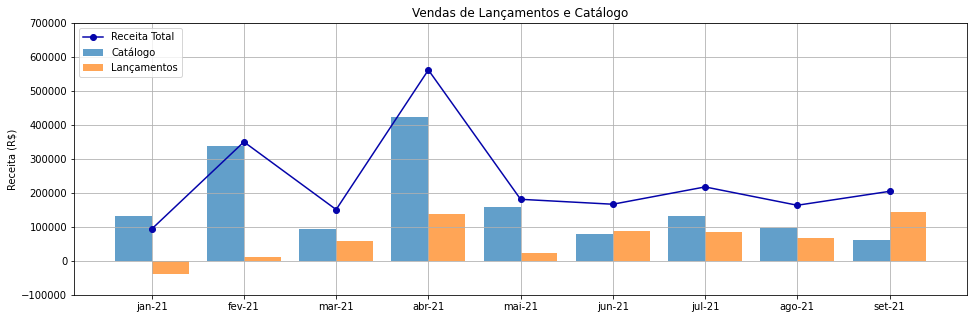

In [9]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 1, 1)

x = tot_l.index[:-1]
y = tot_l[:-1] + tot_c[:-1]
ax1.set_ylim([-100000, 700000])
ax1.plot(x, y, label='Receita Total', marker='o', color='xkcd:royal blue')

width = 0.4
x = list(range(len(x)))
x = list(map(lambda x: x - width/2, x))
y = tot_c[:-1]
ax1.bar(x, y, width=width, label='Catálogo', alpha=0.7)

x = list(range(len(x)))
x = list(map(lambda x: x + width/2, x))
y = tot_l[:-1]
ax1.bar(x, y, width=width, label='Lançamentos', alpha=0.7)

ax1.set_ylabel('Receita (R$)')
ax1.set_title('Vendas de Lançamentos e Catálogo')
ax1.legend(loc='upper left')
ax1.grid()

plt.show()


## Evolução do Saldo Médio e do Giro dos Estoques

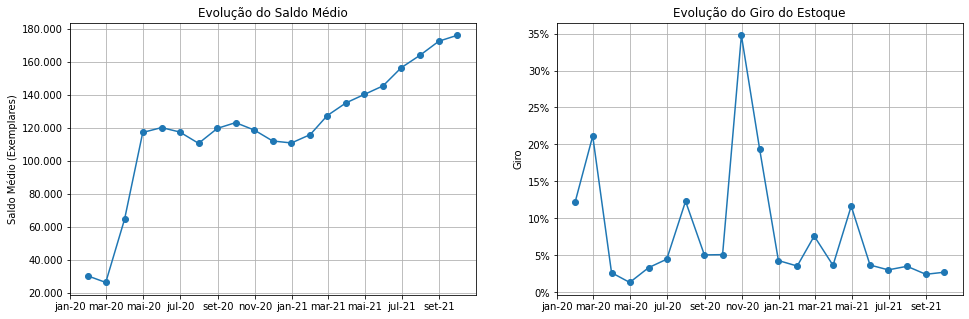

In [10]:
mov = pd.read_pickle(PATH + 'estoques_diarios.pkl')

mov['Saldo Final'] = mov[['Saldo_V', 'Saldo_T', 'Saldo_E']].sum(axis=1)

aux = mov.reset_index().groupby(['ISBN',
                                 pd.Grouper(key='Data', freq='M')])\
            .aggregate({'Saldo_V': 'last', 'Saldo_T': 'last',
                        'Saldo_E': 'last', 'Vendas': 'sum', 'CMV': 'sum',
                        'Saldo Final': 'mean'})\
            .rename({'Saldo Final': 'Saldo Médio'}, axis=1)
            
aux['Giro'] = aux['Vendas'] / aux['Saldo Médio']

aux = aux.groupby('Data')[['Vendas', 'Saldo Médio']].sum()
aux = aux['2020':]
aux['Giro'] = aux['Vendas'] / aux['Saldo Médio']

# Cria Gráfico
#plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(aux['Saldo Médio'], marker='o', linestyle='-')
axs[0].set_title('Evolução do Saldo Médio')
axs[0].set_ylabel('Saldo Médio (Exemplares)')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axs[0].yaxis.set_major_formatter(lambda x, y: locale.format_string('%d', x, grouping=True))
axs[0].grid()

axs[1].plot(aux['Giro'], marker='o', linestyle='-')
axs[1].set_title('Evolução do Giro do Estoque')
axs[1].set_ylabel('Giro')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axs[1].yaxis.set_major_formatter(lambda x, y: f'{x:.0%}')
axs[1].grid()

plt.show()


In [11]:
mov['Saldo Ant'] = mov.groupby(['ISBN'])['Saldo Final'].shift(1, fill_value=0)
mov['Perda'] = mov['Saldo Final'] - mov['Saldo Ant'] - \
    mov['Tiragem'].fillna(0) + mov['Vendas']
mov['Valor Perdas'] = mov['Perda'] * mov['Custo Médio']

aux = mov.reset_index().groupby(pd.Grouper(key='Data', freq='M'))\
    [['Valor Estoques', 'Valor Perdas', 'CMV', 'Custo']].sum()

aux = aux.loc['2020':]

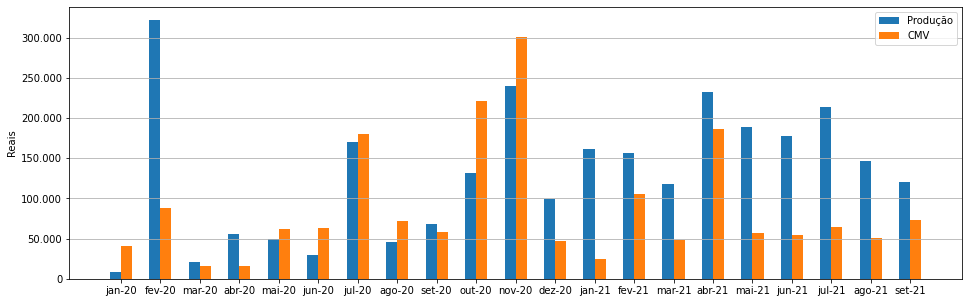

In [12]:
x = np.arange(len(aux.loc['2020':, ].index))
labels = aux.loc['2020':, ].index.strftime('%b-%y')
width = 0.28

fig, axs = plt.subplots(1, 1, figsize=(16, 5))

axs.bar(x - width/2, aux.loc['2020':, 'Custo'], width=width, label='Produção')
axs.bar(x + width/2, aux.loc['2020':, 'CMV'], width=width, label='CMV')
#axs.bar(x + width/2, -aux.loc['2020':, 'Valor Perdas'], width=width, label='Perdas')
axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.set_ylabel('Reais')
axs.legend()
axs.grid(axis='y')

axs.yaxis.set_major_formatter(lambda x, y: locale.format_string('%d', x,
                                                                grouping=True))
plt.show()


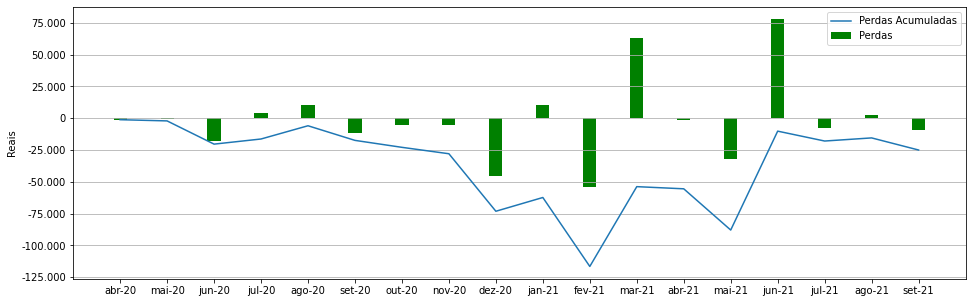

In [13]:
x = np.arange(len(aux.loc['2020-04':, ].index))
labels = aux.loc['2020-04':, ].index.strftime('%b-%y')

fig, axs = plt.subplots(1, 1, figsize=(16, 5))

axs.set_xticks(x)
axs.set_xticklabels(labels)
axs.bar(x, aux.loc['2020-04':, 'Valor Perdas'], width=width, label='Perdas', color='green')
axs.plot(x, aux.loc['2020-04':, 'Valor Perdas'].cumsum(), label='Perdas Acumuladas')
axs.set_ylabel('Reais')
axs.legend()
axs.grid(axis='y')

axs.yaxis.set_major_formatter(lambda x, y: locale.format_string('%d', x,
                                                                grouping=True))
plt.show()


In [14]:
#! jupyter nbconvert --to html  --no-input analise_lancamentos_2.ipynb --output-dir=C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-custo\\html